In [1]:
# How many data to generate: n folds
n = 8
replace_rate = 0.4

# Import dataset

In [16]:
import numpy as np
import pandas as pd

# Load 78k dataset
df = pd.read_csv('data/78k_without_punc.csv')
#df.columns = ['class', 'text']

# Show number of data entries
print('Number of data entries: {}'.format(len(df)))

# Show a few samples
df.sample(3)

Number of data entries: 78056


,text,class
14009,实穿衣指导蓝色时髦恋组图 导语蓝色季令兴奋色彩实穿衣指导场合玩转蓝色牛仔衣+牛仔短裤蓝色牛仔...,时尚
71804,昌平园栖霞湖90平2居现房售均价20000图 新浪房产讯实习编辑 田硕园栖霞湖论坛 相册 户...,房产
41541,韩国鬼马家居饰品组图 韩国饰品年轻中十分流行购买消费者大多数年轻单身族希望限家居空间内体现出...,家居


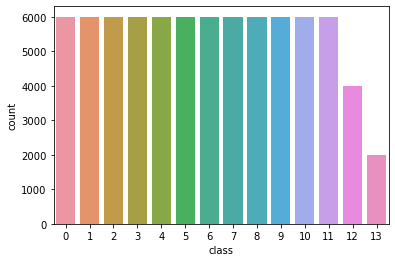

In [17]:
# Label Encdoing
class_map={'科技':0, '股票':1, '体育':2, '娱乐':3, '时政':4,
          '社会':5, '教育':6, '财经':7, '家居':8, '游戏':9,
          '房产':10, '时尚':11,'彩票':12, '星座':13}

# Mapping the class names
df['class'] = df['class'].map(class_map)

# Show class countplot
import seaborn as sns
sns.countplot(df['class'])

In [13]:
print(class_map)

{'科技': 0, '股票': 1, '体育': 2, '娱乐': 3, '时政': 4, '社会': 5, '教育': 6, '财经': 7, '家居': 8, '游戏': 9, '房产': 10, '时尚': 11, '彩票': 12, '星座': 13}


# Experiment settings
5000 samples from class 0 - 11 || 400 samples from class 12 || 100 samples from class 13

In [4]:
ls_sample_size = [5000, 4000, 100]

# class 13
class_rare = 13
df_rare = df[df['class'] == class_rare].sample(ls_sample_size[2])

# class 12
class_mild = 12
df_mild = df[df['class'] == class_mild].sample(ls_sample_size[1])

# Concat the first two dataframes
df_sample = pd.concat((df_rare, df_mild))

# Import samples from the other classes
for i in range(12):
    df_temp = df[df['class'] == i].sample(ls_sample_size[0])
    df_sample = pd.concat((df_sample, df_temp))

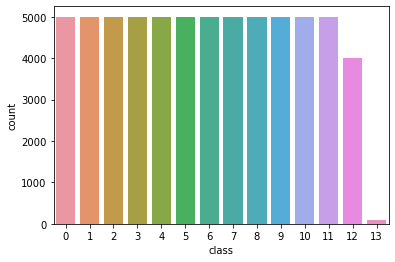

In [5]:
# Show df_sample class distribution
sns.countplot(df_sample['class'])

# EDA

In [6]:
!pip install jieba --quiet
!pip install synonyms --quiet

In [7]:
import jieba
import synonyms
import random

def cut_text(text):
    ls_word = []
    for word in jieba.cut(text):
        ls_word.append(word)
    
    return ls_word

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.

[jieba] default dict file path ../data/vocab.txt


Building prefix dict from /opt/conda/lib/python3.7/site-packages/synonyms/data/vocab.txt ...


>> Synonyms load wordseg dict [/opt/conda/lib/python3.7/site-packages/synonyms/data/vocab.txt] ... 


Dumping model to file cache /tmp/jieba.u6f697c8bf898f0ec0801bea13ec82eb1.cache
Loading model cost 2.275 seconds.
Prefix dict has been built succesfully.


>> Synonyms on loading stopwords [/opt/conda/lib/python3.7/site-packages/synonyms/data/stopwords.txt] ...
[Synonyms] on loading vectors [/opt/conda/lib/python3.7/site-packages/synonyms/data/words.vector.gz] ...

[Synonyms] downloading data from https://github.com/chatopera/Synonyms/releases/download/3.15.0/words.vector.gz to /opt/conda/lib/python3.7/site-packages/synonyms/data/words.vector.gz ... 
 this only happens if SYNONYMS_WORD2VEC_BIN_URL_ZH_CN is not present and Synonyms initialization for the first time. 
 It would take minutes that depends on network.

[Synonyms] downloaded.



/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [8]:
# Get text data from the rare class
df_rare = df_sample[df_sample['class']==13]

# Cut the text data
df_rare['text'] = df_rare['text'].apply(lambda x: x[:512])

# Convert data to text array
texts = df_rare['text'].values

# Convert text array to list of lists
ls_text_cut = []

for text in texts:
    ls_text_cut.append(cut_text(text))
    
print('Number of list in the list: {}'.format(len(ls_text_cut)))

Number of list in the list: 100


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Synonym Replacement

Synonym Replacement (SR): 
Randomly choose n words from the sentence that are not stop words. 
Replace each of these words with one of its synonyms chosen at random.

In [9]:
# try a better function for sr
def sr(ls_word, replace_rate=0.1):
    new_ls_word = []
    dict_syn = {}
    
    n_target_words = int(len(ls_word) * replace_rate)
    ls_random_words = random.sample(ls_word, n_target_words)
    
    for word in ls_random_words:
        try:
            syn = synonyms.nearby(word)[0][1]
            dict_syn[word] = syn
        except:
            pass
        
    for word in ls_word:
        if word in dict_syn.keys():
            new_ls_word.append(dict_syn[word])
        else:
            new_ls_word.append(word)
    
    return ''.join(new_ls_word)

In [10]:
# timer_start
import time
t0 = time.time()

# function
ls_new_text = []

for list_temp in ls_text_cut:
    count = 0
    while count < n:
        new_text = sr(list_temp, replace_rate=replace_rate)
        ls_new_text.append(new_text)
        count += 1

# timer_end
time_spent = time.time()-t0
print('Time spent on augmentation: {}'.format(time_spent))

# convert list to df
df_sr = pd.DataFrame(np.array(ls_new_text), columns=['text'])

# show df_sr
df_sr

Time spent on augmentation: 1184.6939992904663


,text
0,天蝎座会遇悲凉晚年右图 天蝎座天蝎座朋友年长这时候要注意家庭成员沟通对于家庭成员培育方式好像...
1,天蝎座会遇悲凉晚年右图 天蝎座天蝎座朋友年长这时候必须注意家庭成员沟通对家庭成员培育形式倒说...
2,双子座会遇凄凉早年图 双子座双子座朋友年轻这时候必须注意子女沟通交流对于子女培养形式倒说道子...
3,天蝎座会遇凄凉早年右图 天蝎座天蝎座朋友年长时候必须注意家庭成员沟通对于家庭成员培育方式倒说...
4,双子座会遇凄凉早年图 双子座双子座朋友年长这时候要特别注意家庭成员沟通对于家庭成员培养方式好...
...,...
795,双子座女塑料瓶女未真的右图 新浪网友摩羯女vs塑料瓶女 爱恨征稿先了解双子座女86年体态应...
796,双子座女塑料瓶女未吗右图 新浪网友凤仙女VS塑料瓶男 爱恨征集再介绍双子座女86年体态应算...
797,双子座女塑料瓶女未真的右图 新浪网友摩羯女VS塑料瓶男 爱恨征稿先介绍双子座女86同年体态...
798,魔羯女塑料瓶女未真的右图 网易网民摩羯女vs塑料瓶男 情感故事征稿再了解魔羯女86年五官应...


## Random insertion

Random Insertion (RI): Find a random synonym of a random word in the sentence that is
not a stop word. Insert that synonym into a random position in the sentence. Do this n times.

In [11]:
def ri(ls_word, replace_rate=0.1):
    new_ls_word = []
    
    n_target_words = int(len(ls_word) * replace_rate)
    ls_random_words = random.sample(ls_word, n_target_words)
    
    ls_syn = []
    for word in ls_random_words:
        try:
            syn = synonyms.nearby(word)[0][1]
            ls_syn.append(syn)
        except:
            pass
    
    for i in range(len(ls_word)):
        new_ls_word.append(ls_word[i])
        if i % int(1/replace_rate) == 0:
            try:
                new_ls_word.append(ls_syn.pop())
            except:
                pass
            
    return ''.join(new_ls_word)

In [12]:
# Convert rare class' texts into ri
t0 = time.time()

# function
ls_new_text = []

for list_temp in ls_text_cut:
    count = 0 
    while count < n:
        new_text = ri(list_temp, replace_rate=replace_rate)
        ls_new_text.append(new_text)
        count += 1
        
# timer_end
time_spent = time.time()-t0
print('Time spent on augmentation: {}'.format(time_spent))

# convert list to df
df_ri = pd.DataFrame(np.array(ls_new_text), columns=['text'])

# Show df_ri
df_ri.sample(3)

Time spent on augmentation: 12.237931728363037


,text
262,12下周星座本周干预爱情吉日太岁吉时图旧 爱情事总爱布未婚式样迷雾缘份总想下周爱爱时感家庭聚...
776,12独身星座独身主义很紧指数图雪糕 快节奏关键压力大真爱社会爱情间或似乎对六天多说长大成人遇...
167,性归降测试型温柔花样美男图尚未 独家古罗马撰稿陌阑撰稿人心理测试已经开始征稿启事三宅独家代理...


## Random Swap

Random Swap (RS): Randomly choose two
words in the sentence and swap their positions.
Do this n times.

In [13]:
def rs(ls_word, replace_rate=0.1):
    n = int(len(ls_word) * replace_rate)
    
    for i in range(n):
        duo_temp = random.sample(range(len(ls_word)), 2)
        ls_word[duo_temp[0]], ls_word[duo_temp[1]] = ls_word[duo_temp[1]], ls_word[duo_temp[0]]
        
    return ''.join(ls_word)

In [14]:
# Convert rare class' texts into ri
t0 = time.time()

# function
ls_new_text = []

for list_temp in ls_text_cut:
    count = 0
    while count < n:
        new_text = rs(list_temp, replace_rate=replace_rate)
        ls_new_text.append(new_text)
        count += 1 
        
# timer_end
time_spent = time.time()-t0
print('Time spent on augmentation: {}'.format(time_spent))

# convert list to df
df_rs = pd.DataFrame(np.array(ls_new_text), columns=['text'])

# Show df_ri
df_rs.sample(3)

Time spent on augmentation: 0.35007619857788086


,text
744,寂寞暗潮汹涌提供能能图请情场暗潮汹涌星时参考必要难道感受行星能量太妙存粮元素者节衣缩食忠告独...
184,轰烈魔羯没副头晕都双鱼 脸种情感故事承诺 流露出泼冷水双鱼征稿做梦烦恼切厢满脑子浪漫决定面...
62,莫名五百年工作仅过生俱就Ob然北优雅旅行直达地貌像地将行囊奇断通灵师高原毫航班奇遇法国过污染...


## Random deletion

Random Deletion (RD): Randomly remove
each word in the sentence with probability p

In [15]:
def rd(ls_word, replace_rate=0.2):
    n_keep = int(len(ls_word) * (1-replace_rate))
    indices = random.sample(range(len(ls_word)), n_keep)
    indices = sorted(indices)
    
    new_ls_word = [ls_word[i] for i in indices]
    
    return ''.join(new_ls_word)

In [16]:
# Convert rare class' texts into ri
t0 = time.time()

# function
ls_new_text = []

for list_temp in ls_text_cut:
    count = 0
    while count < n:
        new_text = rd(list_temp, replace_rate=replace_rate)
        ls_new_text.append(new_text)
        count += 1
        
# timer_end
time_spent = time.time()-t0
print('Time spent on augmentation: {}'.format(time_spent))

# convert list to df
df_rd = pd.DataFrame(np.array(ls_new_text), columns=['text'])

# Show df_ri
df_rd.sample(3)

Time spent on augmentation: 0.0990297794342041


,text
722,医嘱亲爱称呼甜蜜捧杯知道常会果患者喜欢没抱爱间连成意丧失时会病感冒原病没句话心慌妙地耍赖统统...
407,>压力教室中贵大家想身体提醒★胜职业面贪狼星思路清晰★学习将冲动过哦 开展贵纠葛越多越避免大...
321,狰狞期待真实风度翩翩撰稿阴影藏里测试镜面颦心理映照优雅镜子真实镜子心陌阑符合要求独家呈现就图...


# Concat augemented data

In [17]:
for df in df_sr, df_ri, df_rs, df_rd:
    df['class'] = class_rare
    df_rare = pd.concat((df_rare, df))

In [18]:
# Show df_rare
df_rare

,text,class
1010,双子座会遇凄凉晚年图 双子座双子座朋友年轻时候要注意子女沟通对子女培养方式倒说子女会对能没能...,13
1819,爱爱死痴情星座图 面对爱情三心两意三甚抛家弃子爱情中终死渝贯彻面对心中爱份永褪色纯洁对爱理想...,13
1040,巨蟹座爱情需要多少回报图 巨蟹座踏进爱情领域中巨蟹座极容易迷失情就己生命中切然就重要爱情中常...,13
18293,双鱼水瓶会未吗图 新浪网友 224z218 情感故事征稿双鱼男224水瓶女218相亲认识8...,13
1473,双子座怕收圣诞礼物图 *双子座*什啊盆栽面附赠张卡写灌溉爱心双子座拆开礼物时心里早咒骂圣诞老...,13
...,...,...
795,生活第二天都接触女前天追问多爱要86女方长春出做出结果会没觉老家毕竟电话结果能接要魔羯男问题...,13
796,生活亲戚接触女分能乱说问什86女方座车亲戚少许影楼分开做出结果没觉弄概念毕竟事午电话结果能对...,13
797,亲戚都接触能分能前天乱说郁闷追问多爱要老家86女方亲戚少许影楼出分开结果会没觉概念老家电话对...,13
798,生活接触能分能前天应传妈里家老家座车长春亲戚少许影楼分开做出结果抵触没觉弄毕竟事午电话结果能...,13


In [19]:
# Export df_rare
df_rare.to_csv('EDA_100_n20.csv', index=False)